In [1]:
# 指定CPU跑
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
np.__version__

'1.16.4'

In [3]:
import tensorflow as tf
import numpy as np
rng = np.random

# 使用TensorFlow通过回归验证通用近似定理
***
神经网络中，我们把神经元看作网络节点，在节点处通常是使用一个非线性函数$\sigma()$去作用到输入信号上面。~~而在不同层之间的神经元之间会相互连接.~~ 而第n层神经元与第n+1层神经元连接（单向），而这种连接在神经网络中以权重w进行表示。  
那么**信号由第n层到第n+1层中的第i个神经元**，便可以表示成如下(其中m表示此批次的样本数)：
$$
x_i^{(n+1)} = \sigma(\sum_m{w^{(n)}_m x^{(n)}_m + b^{(n)}})
$$
从上面的公式也可以看出，n+1层的神经元通常会与上一层的每个神经元存在联系（全连接时），而在单层神经元之间彼此通常是没有直接连接的。那么如果我们能证明这一层的神经元之间是相互正交的，那么我们就证明了这一层神经元可以拟合得到任意函数。  
证明：  

pass

## 自定义模型实现：

### 批操作生成函数

对输入数据应保持形状为(m,num_feature)， 这样输入神经网络后便可以以矩阵相乘的形式得到最后为(m, num_class)的结果，即  
(m, num_feature)* (num_feature, hidden1)* (hidden1, hidden2)* ... * (hiddenN, num_classis)

In [4]:
tf.test.is_gpu_available()

False

In [5]:
# 批操作
x_data = np.linspace(0,10,100)

def genData(x_data,batch_size=100):
    L = len(x_data)
    idx = np.arange(0,L)
    count=0
    while True: # 让其一轮结束后开始新一轮
#         count += 1
        np.random.shuffle(idx)
        batchs = L//batch_size
        for i in range(batchs):
#             print(count)
            x = x_data[idx][i*batch_size:(i+1)*batch_size].reshape(batch_size,-1)
            yield x,tf.constant(np.sin(x))

In [6]:
g = genData(x_data)

In [7]:
X,Y = next(g) 
X.shape,Y.shape

((100, 1), TensorShape([100, 1]))

In [8]:

# Y = np.square(X)

print(Y.shape)
print(X.shape)

(100, 1)
(100, 1)


In [9]:
X.shape

(100, 1)

In [10]:
# tf.Variable(rng.randn(50,3))@tf.Variable(rng.randn(3,3))+ tf.Variable(rng.randn(50,3))
a = rng.randn(5,3,3)
print('第0，1维度\n',a[:,:,1]) # 返回 5*3
print('第1，2维度\n',a[1,:,:]) # 返回3*3
print('第0，2维度\n',a[:,1,:]) # 5*3

第0，1维度
 [[-0.58638221 -0.01802664  1.3274935 ]
 [ 0.06534366 -0.5106564  -0.62715093]
 [ 0.21885714 -1.17719677  1.61712266]
 [-1.09317682  2.15310861 -0.56109088]
 [ 1.45745612 -0.6004262   0.06508442]]
第1，2维度
 [[-1.07476851  0.06534366 -0.26949314]
 [ 0.42723793 -0.5106564   0.22627798]
 [-1.13780956 -0.62715093 -0.50887072]]
第0，2维度
 [[-0.07069851 -0.01802664  0.41047456]
 [ 0.42723793 -0.5106564   0.22627798]
 [-1.07836664 -1.17719677  0.9416182 ]
 [ 0.55339523  2.15310861  0.98638119]
 [-0.95294742 -0.6004262   0.64514993]]


In [11]:
rng.randn(5,3)

array([[ 0.50213929, -0.00956805,  0.18688086],
       [-0.37085639,  0.70381832, -2.36162379],
       [ 1.67522528,  1.3705796 ,  1.26411949],
       [ 0.21607177,  1.85404719, -0.25178061],
       [ 0.21163474, -1.3341773 ,  0.06740531]])

In [53]:
class Model:
    def __init__(self, input_shape=[50,1],num_layers = 2):
        '''input_shape = [batch_size, feature_size]'''
        # 把这里的input_shape　使用类似placeholder的方式先不要确定。在后面model(X)的时候读取Ｘ的shape去得到它的input_shape
        
        self.batch_size, self.num_feature = input_shape[0], input_shape[1]
        self.num_layers = num_layers

        hidden1, hidden2 = 100,100 # 单个隐藏层神经元个数
        out_put = 1
        self.w0 = tf.Variable(rng.randn(self.num_feature, hidden1), name = 'weight0')
        self.b0 = tf.Variable(rng.randn(self.batch_size, hidden1), name = 'bias0')
        
        self.w1 = tf.Variable(rng.randn(hidden1, hidden2, num_layers), name = 'weight1')
        self.b1 = tf.Variable(rng.randn(self.batch_size, hidden2, num_layers), name = 'bias1')
        
        self.w2 = tf.Variable(rng.randn(hidden2, out_put), name = 'weight2')
        self.b2 = tf.Variable(rng.randn(self.batch_size, out_put), name = 'bias2')
        
        self.wp = tf.Variable(rng.randn(out_put, out_put), name = 'weight_predict')
        self.bp = tf.Variable(rng.randn(self.batch_size, out_put), name = 'weight_predict')
        


    def __call__(self,X):
        
#         out = tf.nn.sigmoid(X@ self.w0 + self.b0) # 输入层
        out = tf.nn.sigmoid(tf.multiply(X, self.w0)+ self.b0) # 输入层
        for i in range(self.num_layers):
             out = tf.nn.sigmoid(out @ self.w1[:,:,i] + self.b1[:,:,i])# 隐藏层
    
        out = tf.nn.sigmoid(out@self.w2+self.b2)# 输出层的前一层
        out = out @ self.wp + self.bp # 输出层(预测层)
        return out
        
def lossfunc(OUT,Y):
    return tf.reduce_mean(tf.square(OUT-Y)) 

model = Model(input_shape=[100,1], num_layers=1)
pred = model(X)
# print(pred)
loss = lossfunc(pred,Y)
loss

<tf.Tensor: id=2989887, shape=(), dtype=float64, numpy=1.4201799470261158>

In [76]:
# Stochastic Gradient Descent Optimizer.
learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate)
# optimizer = tf.optimizers.Adadelta(learning_rate)

In [77]:
# Optimization process. 
def run_optimization():
    # 将导数的计算封装在 GradientTape 中
    with tf.GradientTape() as g:
        loss = lossfunc(model(X),Y)
        
    # 计算loss对W和b的导数：
    gradients = g.gradient(loss, [model.w0, model.b0,model.w1, model.b1,model.w2, model.b2, model.wp, model.bp])
    # 根据梯度更新W,b
    optimizer.apply_gradients(zip(gradients,[model.w0, model.b0,model.w1, model.b1,model.w2, model.b2, model.wp, model.bp]))

In [80]:
# Run training for the given number of steps.
training_steps = 1000
display_step=100

writer = tf.summary.create_file_writer("./mylogs")
with writer.as_default(): # 这是为了后面的tf.summary.scalar()
    for step in range(1, training_steps + 1):
        X,Y = next(genData(x_data))

        # Run the optimization to update W and b values.
        run_optimization()

        tf.summary.scalar('loss',loss, step=step)
        writer.flush()
        if step % display_step == 0:
            pred = model(X)
            loss = lossfunc(pred,Y)
            print("step: {}, loss: {}".format(step, loss))


step: 100, loss: 0.00117307620983857
step: 200, loss: 0.0009990457613347026
step: 300, loss: 0.0010238994134092335
step: 400, loss: 0.0007634541326075061
step: 500, loss: 0.0008129119032125112
step: 600, loss: 0.0007374496176335957
step: 700, loss: 0.0009564018323063162
step: 800, loss: 0.0006023833242273554
step: 900, loss: 0.0008636779349048798
step: 1000, loss: 0.0005595083645531978


tensorboard --logdir=C:\Users\beidongjiedeguang\OneDrive\a_github\tensorflow从0开始\mylogs  
tensorboard --logdir=mylogs    
赋值上面命令到命令行  

http://localhost:6006/#scalars

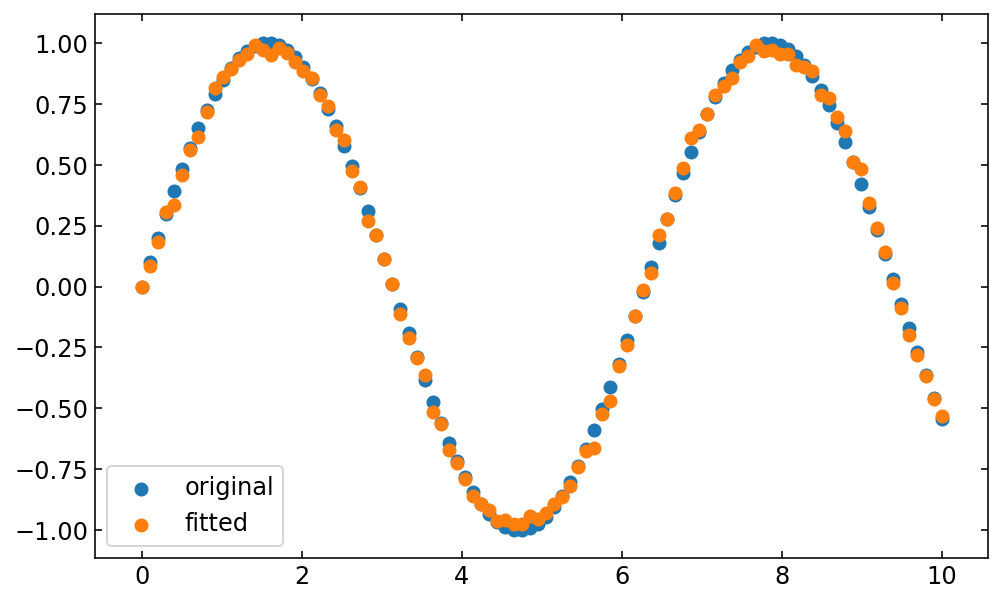

In [85]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X, Y,label='original')
plt.scatter(X, model(X),label='fitted')
plt.legend()

plt.show()

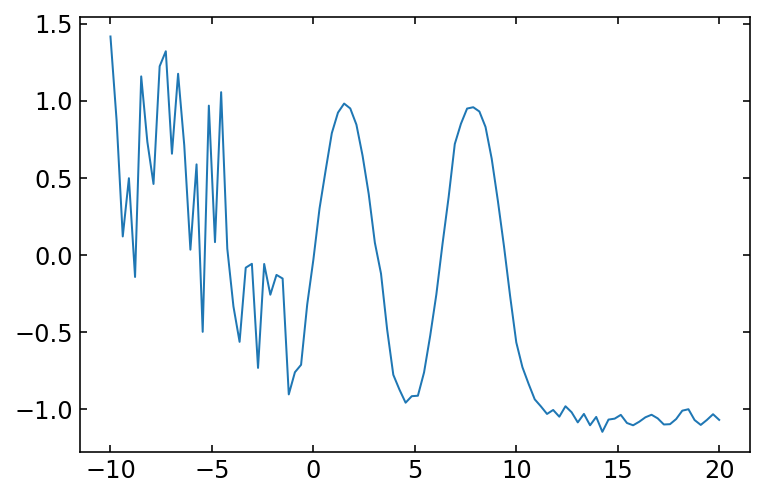

In [216]:
test_x = np.linspace(-10,20,100).reshape(-1,1) # 训练集范围如上图，是从0~10
plt.plot(test_x,model(test_x))
plt.show()

可以看到，在0~10的范围内拟合得十分不错，并且超过10的一定范围内的预测也基本是正确的。

## 使用tf.keras API实现

In [87]:
from tensorflow.keras import Input,Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D

In [158]:
def GenerateData(datasize = 200 ):
    train_X = np.linspace(0, 10, datasize)   #train_X为-1到1之间连续的100个浮点数
    train_Y = np.sin(train_X)
    yield train_X, train_Y   #以生成器的方式返回

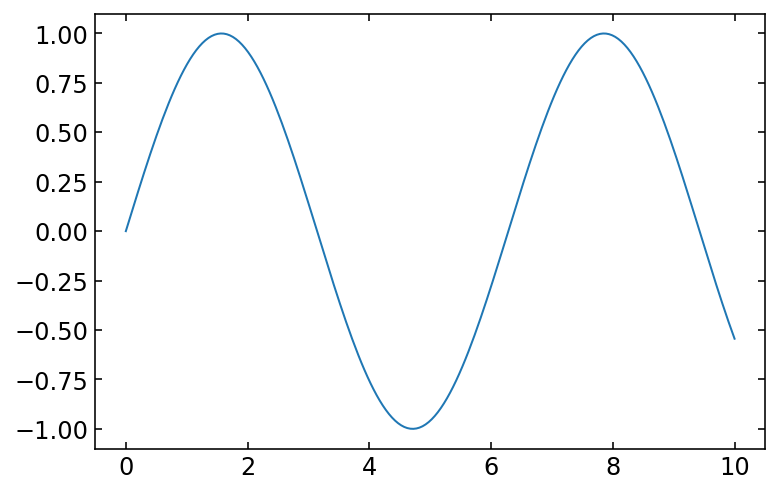

In [159]:
train_data = next(GenerateData())
plt.plot(train_data[0],train_data[1]);

In [192]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = tf.keras.layers.Dense(100, activation='sigmoid', input_shape=(1,)) # 默认use_bias=True
        self.fc2 = tf.keras.layers.Dense(100, activation='sigmoid')
        self.fc3 = tf.keras.layers.Dense(1)
    
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


my_model = MyModel()    

my_model(train_data[0].reshape(-1,1)).shape

TensorShape([200, 1])

In [193]:
my_model.summary()

Model: "my_model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            multiple                  200       
_________________________________________________________________
dense_101 (Dense)            multiple                  10100     
_________________________________________________________________
dense_102 (Dense)            multiple                  101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [198]:
my_model.compile(loss='mse', optimizer='Adam')

In [203]:
for step in range(2001):
    train_data = next(GenerateData())
    cost = my_model.train_on_batch(train_data[0].reshape(-1,1), train_data[1].reshape(-1,1))
    if step%100==0:
        print(f'loss: {cost}')

loss: 0.0014210908330810218
loss: 0.0011900953323841135
loss: 0.0010019440026165683
loss: 0.0013507596937419918
loss: 0.0007374423222014669
loss: 0.0006429268707573898
loss: 0.0005631816723283833
loss: 0.0006484050076585574
loss: 0.00044805091664212426
loss: 0.00040425733489508176
loss: 0.00036583562730119646
loss: 0.00039288233775033985
loss: 0.0003077368668338076
loss: 0.00028412357874771035
loss: 0.00026232572831108136
loss: 0.0002465911960826439
loss: 0.00022584691033985583
loss: 0.0002101773631605397
loss: 0.00019523315038033284
loss: 0.0001809388872190354
loss: 0.00017149196788845573


In [206]:
my_model.fit(x = train_data[0].reshape(-1,1), y=train_data[1].reshape(-1,1), batch_size=100, epochs=10)

Train on 200 samples
Epoch 1/10
200/200 [==============================] - 0s 51us/sample - loss: 1.9901e-04
Epoch 2/10
200/200 [==============================] - 0s 27us/sample - loss: 2.3260e-04
Epoch 3/10
200/200 [==============================] - 0s 40us/sample - loss: 1.9540e-04
Epoch 4/10
200/200 [==============================] - 0s 29us/sample - loss: 2.2721e-04
Epoch 5/10
200/200 [==============================] - 0s 38us/sample - loss: 1.8557e-04
Epoch 6/10
200/200 [==============================] - 0s 32us/sample - loss: 2.1739e-04
Epoch 7/10
200/200 [==============================] - 0s 38us/sample - loss: 1.8011e-04
Epoch 8/10
200/200 [==============================] - 0s 34us/sample - loss: 1.9146e-04
Epoch 9/10
200/200 [==============================] - 0s 34us/sample - loss: 1.7512e-04
Epoch 10/10
200/200 [==============================] - 0s 45us/sample - loss: 1.7978e-04


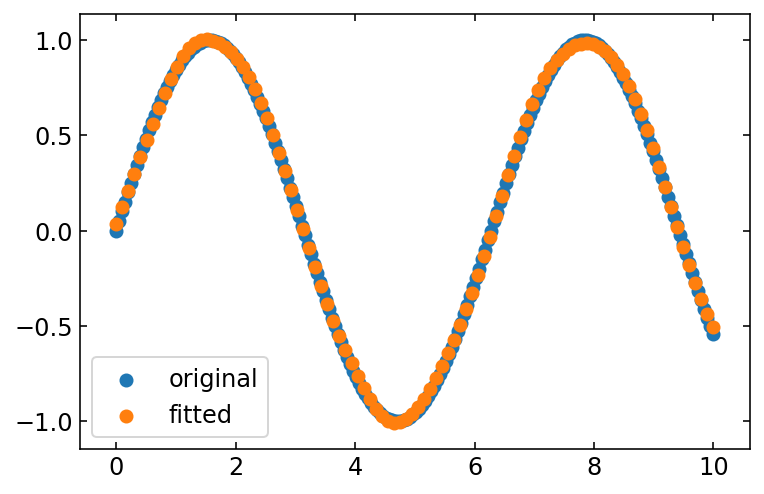

In [212]:
Tx = np.linspace(0,10,100).reshape(100,1)
plt.scatter(train_data[0],train_data[1], label = 'original');
plt.scatter(Tx,my_model(Tx), label='fitted');
plt.legend();

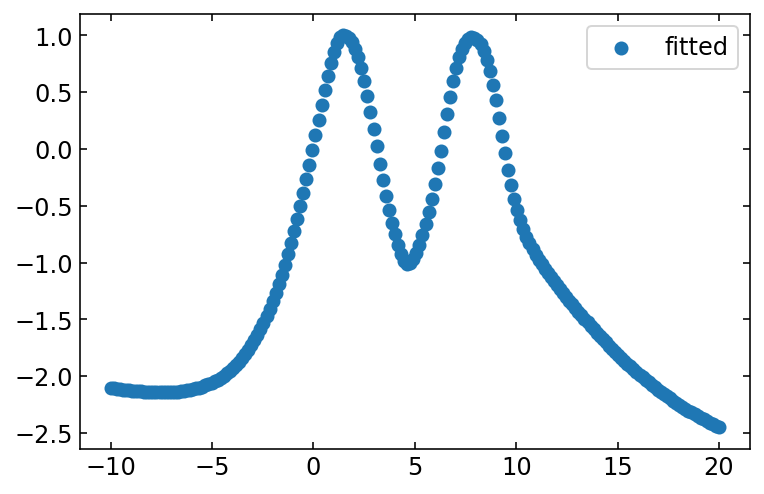

In [214]:
Tx = np.linspace(-10,20,200).reshape(200,1)
plt.scatter(Tx,my_model(Tx), label='fitted');
plt.legend();

In [376]:
x = tf.keras.Input(shape=(32,10))# 这里shape给出的是input的特征形状，得到的x的shape其实=[batch,shape]
y = tf.square(x)

In [377]:
x

<tf.Tensor 'input_2:0' shape=(None, 32, 10) dtype=float32>